In [36]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [37]:
TRIANGLE = 3
SQUARE = 4
PENTAGON = 5
HEXAGON = 6

In [38]:
def add_polygon(base_img, x, y, d, angle, color_rgba, p):
    assert p > 2, "Polygon must have at least 3 vertices"

    layer = Image.new("RGBA", base_img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(layer)

    points = []
    for i in range(p):
        ang = 2 * np.pi * i / p + angle
        px = x + d * np.cos(ang)
        py = y + d * np.sin(ang)
        points.append((px, py))

    draw.polygon(points, fill=tuple(color_rgba))
    return Image.alpha_composite(base_img, layer)

In [ ]:
def render_image_from_individual(individual, width, height, p=TRIANGLE, background=(0, 0, 0, 255)):
    base_img = Image.new("RGBA", (width, height), background)
    draw = ImageDraw.Draw(base_img)
    for gene in individual:
        (x, y) = gene[0]
        d = gene[1]
        angle = gene[2]
        color = gene[3]  # [r,g,b,a]

        points = []
        for i in range(p):
            ang = 2 * np.pi * i / p + angle
            px = x + d * np.cos(ang)
            py = y + d * np.sin(ang)
            points.append((px, py))

        draw.polygon(points, fill=tuple(color ))

        # base_img = add_polygon(base_img, x, y, d, angle, color, p)

    return np.array(base_img.convert("RGB"))  # do fitness w RGB

In [40]:
def generate_individual(width, height, num_polygons=100, d_min=5, d_max=200, a_min=50, a_max=255):
    individual = []
    for _ in range(num_polygons):
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)
        distance = np.random.randint(d_min, d_max + 1)
        angle = np.random.uniform(0, 2 * np.pi)
        color = [
            np.random.randint(0, 256),   # r
            np.random.randint(0, 256),   # g
            np.random.randint(0, 256),   # b
            np.random.randint(a_min, a_max + 1)  # a
        ]
        individual.append([(x, y), distance, angle, color])
    return individual

In [41]:
def calculate_fitness_score(image1_rgb, image2_rgb):
    # oba powinny być RGB (H,W,3)
    diff = image1_rgb.astype(np.int64) - image2_rgb.astype(np.int64)
    return np.sum(diff * diff)

In [42]:
def create_population(n, t, im_height, im_width):
    return [generate_individual(im_width, im_height, t) for _ in range(n)]

In [43]:
def copy_individual(ind):
    # bezpieczna kopia: kopiuje listy wewnętrzne (x,y) i color
    new_ind = []
    for (xy, d, ang, col) in ind:
        new_ind.append([ (xy[0], xy[1]), int(d), float(ang), [int(col[0]), int(col[1]), int(col[2]), int(col[3])] ])
    return new_ind

In [44]:
def mutate(ind, t, im_height, im_width,
           pos_step=15, dist_step=15, ang_step=np.pi/8, col_step=15,
           d_min=5, d_max=200):
    idx = np.random.randint(0, t)
    gene = ind[idx]

    prob = np.random.rand()

    if prob < 0.25:
        # mutacja środka (x,y)
        x, y = gene[0]
        x = int(np.clip(x + np.random.randint(-pos_step, pos_step + 1), 0, im_width - 1))
        y = int(np.clip(y + np.random.randint(-pos_step, pos_step + 1), 0, im_height - 1))
        gene[0] = (x, y)

    elif prob < 0.5:
        # mutacja dystansu
        d = gene[1] + np.random.randint(-dist_step, dist_step + 1)
        gene[1] = int(np.clip(d, d_min, d_max))

    elif prob < 0.75:
        # mutacja kąta
        gene[2] = float(gene[2] + np.random.uniform(-ang_step, ang_step))

    else:
        # mutacja koloru (r,g,b,a)
        color = gene[3]
        c_idx = np.random.randint(0, 4)
        color[c_idx] = int(np.clip(color[c_idx] + np.random.randint(-col_step, col_step + 1), 0, 255))

In [45]:
def es_elitism(n, m, t, generations, original_image_rgb, p=TRIANGLE, vis_every=50):
    height, width, _ = original_image_rgb.shape
    per_parent_children = (n - m) // m

    population = create_population(n, t, height, width)
    fitness_scores = np.zeros(n, dtype=np.float64)

    for i in range(n):
        curr_im = render_image_from_individual(population[i], width, height, p=p)
        fitness_scores[i] = calculate_fitness_score(original_image_rgb, curr_im)
        print(f"Initial fitness score[{i}]: {fitness_scores[i]}")

    # wizualizacja setup
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    ax_flat = axes.flatten()

    ax_flat[0].imshow(original_image_rgb)
    ax_flat[0].set_title("Original")
    ax_flat[0].axis("off")

    plt.close()

    for generation in range(generations):
        sorted_indices = np.argsort(fitness_scores)
        top_idx = sorted_indices[:m]          # elita: m najlepszych
        rest_idx = sorted_indices[m:]         # reszta (zastępowani)

        if generation % vis_every == 0:
            best = fitness_scores[top_idx[0]]
            for k in range(min(5, m)):
                idx = top_idx[k]
                img = render_image_from_individual(population[idx], width, height, p=p)
                ax_plot = ax_flat[k + 1]
                ax_plot.clear()
                ax_plot.imshow(img)
                ax_plot.set_title(f"Top {k+1} @ gen {generation}\nloss={best:.0f}" if k == 0 else f"Top {k+1} @ gen {generation}")
                ax_plot.axis("off")

            clear_output(wait=True)
            display(fig)

        # generowanie dzieci: elita produkuje potomków i nadpisuje najgorszych
        child_num = 0
        for parent_idx in top_idx:
            for _ in range(per_parent_children):
                if child_num >= len(rest_idx):
                    break
                target = rest_idx[child_num]

                population[target] = copy_individual(population[parent_idx])
                mutate(population[target], t, height, width)

                curr_im = render_image_from_individual(population[target], width, height, p=p)
                fitness_scores[target] = calculate_fitness_score(original_image_rgb, curr_im)

                child_num += 1

    best_idx = int(np.argmin(fitness_scores))
    return best_idx, population[best_idx], float(fitness_scores[best_idx])

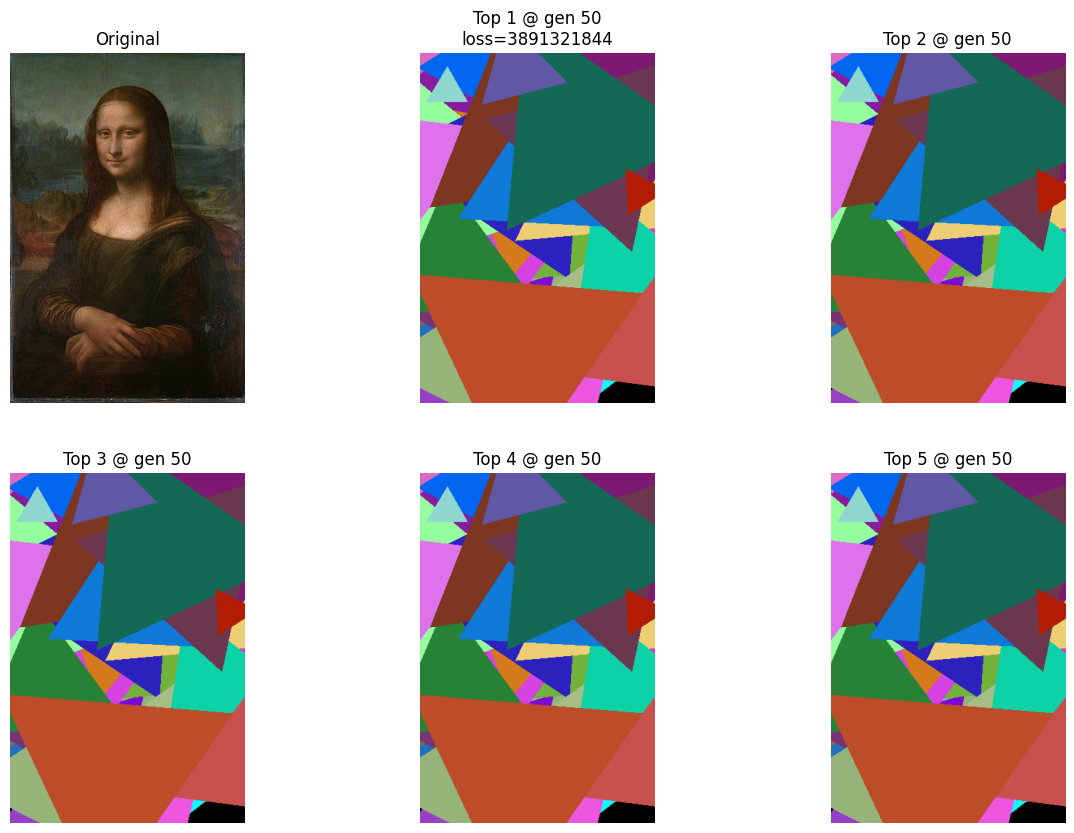

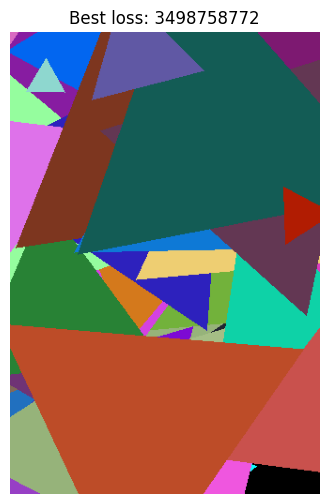

In [46]:
image_path = "MonaLisaS.jpg"
original_rgb = np.array(Image.open(image_path).convert("RGB"))

N = 20
M = 5
T = 100
GENERATIONS = 100

best_idx, best_ind, best_loss = es_elitism(N, M, T, GENERATIONS, original_rgb, p=TRIANGLE, vis_every=50)

best_img = render_image_from_individual(best_ind, original_rgb.shape[1], original_rgb.shape[0], p=TRIANGLE)
plt.figure(figsize=(6,6))
plt.imshow(best_img)
plt.axis("off")
plt.title(f"Best loss: {best_loss:.0f}")
plt.show()


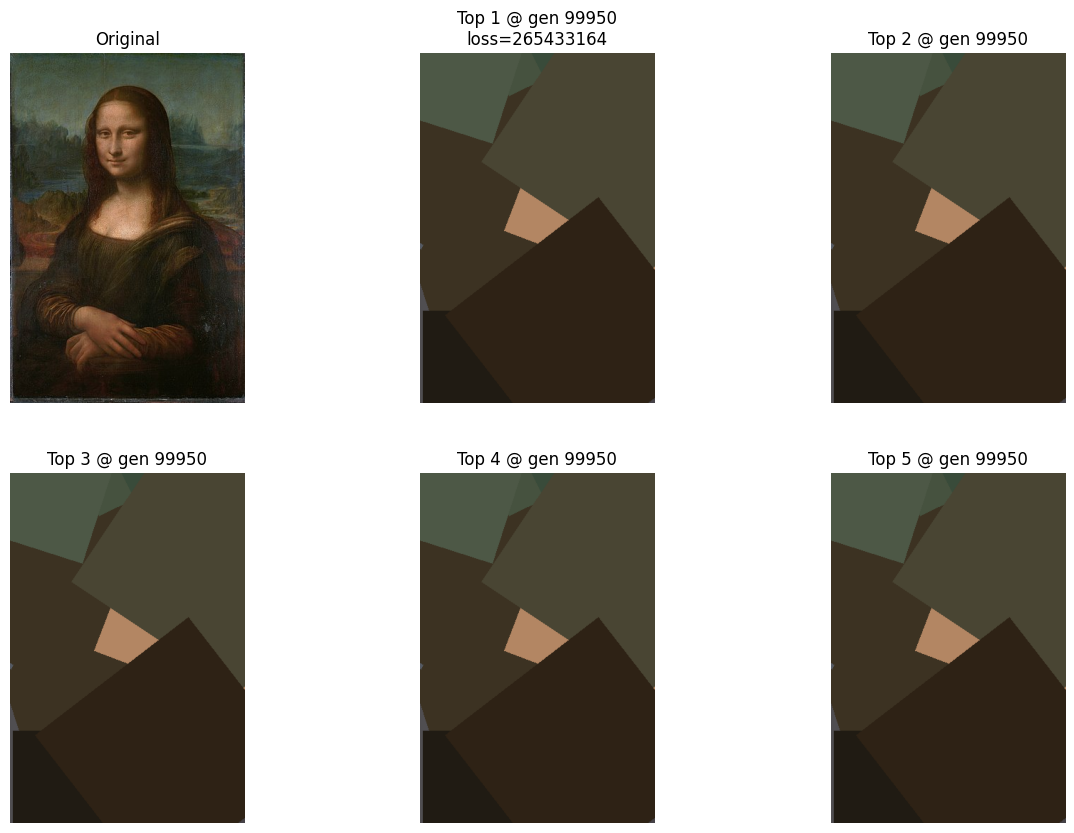

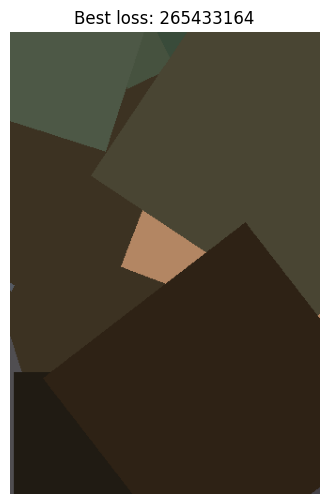

In [47]:
image_path = "MonaLisaS.jpg"
original_rgb = np.array(Image.open(image_path).convert("RGB"))

N = 20
M = 5
T = 80
GENERATIONS = 100000

best_idx, best_ind, best_loss = es_elitism(N, M, T, GENERATIONS, original_rgb, p=SQUARE, vis_every=50)

best_img = render_image_from_individual(best_ind, original_rgb.shape[1], original_rgb.shape[0], p=SQUARE)
plt.figure(figsize=(6,6))
plt.imshow(best_img)
plt.axis("off")
plt.title(f"Best loss: {best_loss:.0f}")
plt.show()